In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from skimage import data,filters
import scipy.ndimage as ndimage
import numpy as np
from PIL import Image
from math import floor, ceil
import cv2
import os
import math
import pandas as pd
import random
import signal

In [42]:
lego1 = plt.imread("CVassignment3_files/lego1.jpg")
lego2 = plt.imread("CVassignment3_files/lego2.jpg")
height = 9.6
width = 16
length = 32
colour = (255, 255, 0)
x_col = (255, 0, 0)
y_col = (0, 255, 0)
z_col = (0, 0, 255)

pts_x = [[x*length, 192, 0] for x in range(0,8)]
pts_y = [[240, x*length, 0] for x in range(0,6)]
pts_z = [[240, 192, x*height] for x in range(0,14)]
pts_z.reverse()
pts_x.reverse()
pts = pts_z + pts_y + pts_x
pts = np.asarray(pts)

pts_1 =np.array([[1004,  812],
       [1004,  884],
       [1004,  960],
       [1000, 1032],
       [1004, 1108],
       [1004, 1184],
       [ 996, 1260],
       [1004, 1336],
       [1004, 1408],
       [1004, 1484],
       [1004, 1560],
       [1000, 1632],
       [ 996, 1704],
       [ 996, 1776],
       [ 244, 1448],
       [ 360, 1504],
       [ 476, 1552],
       [ 600, 1608],
       [ 728, 1664],
       [ 860, 1716],
       [1104, 1764],
       [1308, 1728],
       [1508, 1688],
       [1700, 1652],
       [1888, 1616],
       [2072, 1580],
       [2256, 1544],
       [2428, 1512]])


pts_2 = np.array([
    [1568, 770],
    [1568, 856],
    [1576, 948],
    [1568, 1028],
    [1572, 1108],
    [1564, 1196],
    [1568, 1280],
    [1564, 1360],
    [1560, 1440],
    [1556, 1524],
    [1560, 1608],
    [1556, 1684],
    [1560, 1768],
    [1556, 1848],
    [208, 1584],
    [416, 1624],
    [628, 1668],
    [852, 1716],
    [1084, 1752],
    [1316, 1804],
    [1624, 1816],
    [1756, 1744],
    [1884, 1676],
    [2004, 1620],
    [2124, 1556],
    [2232, 1492],
    [2336, 1432],
    [2436, 1380],
])

def decomposeP(P):
    # The input P is assumed to be a 3−by−4 homogeneous camera matrix.
    # The function returns a homogeneous 3−by−3 calibration matrix K,
    # a 3−by−3 rotation matrix R and a 3−by−1 vector c such that
    # K*R*[eye(3), −c] = P.
    W = np.array([[0,0,1],
                  [0,1,0],
                  [1,0,0]])
    # calculate K and R (up to sign)
    t = np.dot(W, P[:,0:3])
    Qt,Rt = np.linalg.qr(t.T)
    K = np.dot(W,np.dot(Rt.T,W))
    R = np.dot(W,Qt.T)

    # correct for negative focal length(s) if necessary
    D = np.array([[1,0,0],
                  [0,1,0],
                  [0,0,1]])    
    if K[0,0] < 0:
        D[0,0] = -1
    if K[1,1] < 0: 
        D[1,1] = -1
    if K[2,2] < 0:
        D[2,2] = -1
    K = np.dot(K,D)
    R = np.dot(D,R)

    # calculate c
    c = -1*np.dot(R.T, np.dot(np.linalg.inv(K), P[:,3]))
    return K,R,c

def scale(ma):
    """
    Take numpy matrix ma of size m,n and divide it by ma[m,n]
    """
    a = ma.shape
    return ma/ma[a[0]-1,a[1]-1]

def plot_lego_2d():
    lego1 = plt.imread("CVassignment3_files/lego1.jpg")
    lego2 = plt.imread("CVassignment3_files/lego2.jpg")
    
    for i in range(0, len(pts_2)):
        cv2.circle(lego1,(pts_1[i][0],pts_1[i][1]), 20, colour, thickness=-1)
        cv2.circle(lego2,(pts_2[i][0],pts_2[i][1]), 20, colour, thickness=-1)
    
    x = [(996, 1776), (244, 1448)]
    y = [(996, 1776),(1004,  812)]
    z = [(996, 1776), (2428, 1512)]
    cv2.line(lego1, x[0], x[1], y_col,5)
    cv2.line(lego1, y[0], y[1], z_col,5)
    cv2.line(lego1, z[0], z[1], x_col,5)
    x = [(1556, 1848), (1568, 770)]
    y = [(1556, 1848),(208, 1584)]
    z = [(1556, 1848), (2436, 1380)]
    cv2.line(lego2, x[0], x[1], z_col,5)
    cv2.line(lego2, y[0], y[1], y_col,5)
    cv2.line(lego2, z[0], z[1], x_col,5)

    plt.imshow(lego1)
    plt.show()
    plt.imshow(lego2)
    plt.show()
    
def plot_lego_3d():
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter([x[0] for x in pts],[x[1] for x in pts] ,[x[2] for x in pts])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
    

def get_P(x, X):
    # 2d => x, 3d => X    
    A = [] 
    for i in range(0, len(x)):
        yX = x[i][1]*X[i]
        xX = x[i][0]*X[i]
        A.append([0,0,0,0,-X[i][0],-X[i][1],-X[i][2],-1,yX[0],yX[1],yX[2],x[i][1]])
        A.append([X[i][0],X[i][1],X[i][2],1,0,0,0,0,-xX[0],-xX[1],-xX[2],-x[i][0]])
    A = np.asarray(A)
    _,_,V = np.linalg.svd(A)
    p =V.T[:,V.shape[1] - 1]
    P = np.array([
        [p[0],p[1],p[2],p[3]],
        [p[4],p[5],p[6],p[7]],
        [p[8],p[9],p[10],p[11]],
    ])
    return P

def check_P(image, P, points):
    for x in points:
        x = P.dot(np.array([x[0],x[1],x[2],1]))
        cv2.circle(image,(int(x[0]/x[2]),int(x[1]/x[2])), 20, colour, thickness=-1)
    plt.imshow(image)
    plt.show()

## Plot Lego

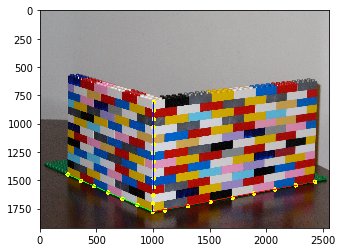

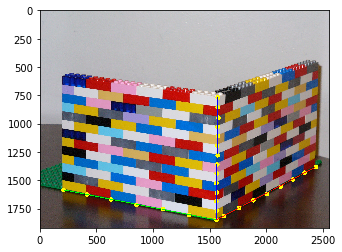

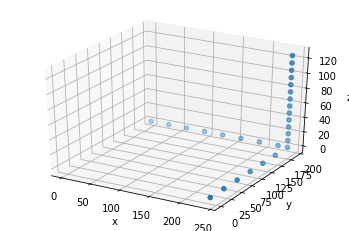

In [43]:
plot_lego_2d()
plot_lego_3d()

# Question 1
## 1a

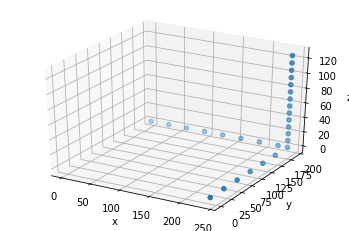

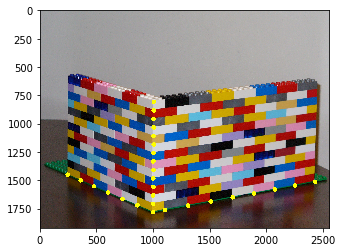

[[-2.82478627e-03  1.53037239e-03  3.55151155e-06  7.89477938e-01]
 [ 1.98822973e-04  3.18710351e-04 -3.16904568e-03  6.13762033e-01]
 [-1.67979269e-07 -2.61737423e-07 -1.31199814e-08  4.96249740e-04]]


In [44]:
P1 = get_P(pts_1, pts)
lego1 = plt.imread("CVassignment3_files/lego1.jpg")
plot_lego_3d()
check_P(lego1,P1,pts)
print(P1)

## 1c

In [45]:
K1,R1,c1 = decomposeP(P1)
print(scale(K1))
print(R1)
print(c1)

[[ 1.02926668e+04 -2.80222826e+01  7.62709300e+02]
 [ 0.00000000e+00  1.02224938e+04 -7.76492498e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-0.84162198  0.54006496  0.00151166]
 [ 0.02149181  0.03628877 -0.99911022]
 [-0.53963928 -0.84084063 -0.0421484 ]]
[ 962.23470708 1259.3519143   380.69659161]


# Question 2
## 2a
### 2a.1

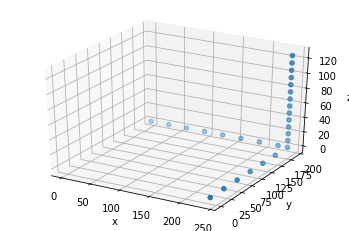

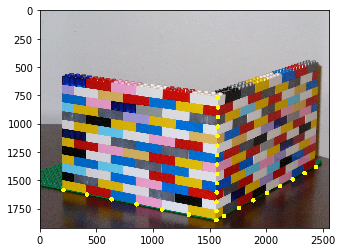

[[ 2.54958646e-03 -3.20297255e-03  9.79570624e-05 -7.16267413e-01]
 [-4.19267076e-04 -2.96162517e-04  4.06830273e-03 -6.97801594e-01]
 [ 3.49060870e-07  2.17847501e-07  9.94474945e-08 -5.87805723e-04]]


In [46]:
P2 = get_P(pts_2, pts)
lego2 = plt.imread("CVassignment3_files/lego2.jpg")
plot_lego_3d()
check_P(lego2,P2,pts)
print(P2)

### 2a.2

In [47]:
K2,R2,c2 = decomposeP(P2)
print(scale(K2))
print(R2)
print(c2)

[[9.60784269e+03 3.46970355e+01 1.12697112e+03]
 [0.00000000e+00 9.62639678e+03 1.08105152e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 0.53086514 -0.84742756 -0.00698129]
 [-0.19549222 -0.13047219  0.97198755]
 [ 0.8245999   0.51462952  0.23492864]]
[1149.04138887  701.44731822  341.00196413]


## 2b

In [87]:
dist = np.sqrt(np.sum((c1-c2)**2, axis=0))
vec = [0,0,1]
v1 = np.dot(R1, vec)
v2 = np.dot(R2, vec)
m1 = 1
m2 = 1
angle = np.arccos(abs(np.dot(v1, v2)))

print(f"Distance: {dist}")
print(f"Angle: {np.rad2deg(angle)}")

Distance: 589.6863048652049
Angle: 11.176389535701448


## 2c

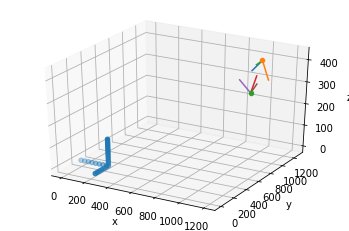

In [68]:
def plot_cameras_3d(c1, R1,c2, R2):
    starts = np.array([[0,0,0],[0,0,0],[0,0,0]])
    ends = np.array([[100,0,0], [0,100,0], [0,0,100]])
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter([x[0] for x in pts],[x[1] for x in pts] ,[x[2] for x in pts])
    ax.scatter(c1[0],c1[1],c1[2])
    ax.scatter(c2[0],c2[1],c2[2])
    
    starts_1 = [R1.dot(x) + c1 for x in starts]
    ends_1 = [R1.dot(x) + c1 for x in ends]
    starts_x = [x[0] for x in starts_1]
    starts_y = [x[1] for x in starts_1]
    starts_z = [x[2] for x in starts_1]
    ends_x = [x[0] for x in ends_1]
    ends_y = [x[1] for x in ends_1]
    ends_z = [x[2] for x in ends_1]
    for i in range(3):
        ax.plot([starts_x[i], ends_x[i]], [starts_y[i],ends_y[i]],zs=[starts_z[i],ends_z[i]])
    
    starts_2 = [R2.dot(x) + c2 for x in starts]
    ends_2 = [R2.dot(x) + c2 for x in ends]
    starts_x = [x[0] for x in starts_2]
    starts_y = [x[1] for x in starts_2]
    starts_z = [x[2] for x in starts_2]
    ends_x = [x[0] for x in ends_2]
    ends_y = [x[1] for x in ends_2]
    ends_z = [x[2] for x in ends_2]
    for i in range(3):
        ax.plot([starts_x[i], ends_x[i]], [starts_y[i],ends_y[i]],zs=[starts_z[i],ends_z[i]])
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

plot_cameras_3d(c1, R1,c2, R2)